Study of following gist code  
https://gist.github.com/gyu-don/f7af13e32f9b18010c75ffdb825f97f0

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import collections
from blueqat import Circuit, BlueqatGlobalSetting
from blueqat.pauli import I, X, Y, Z
import torch
import torchvision

In [2]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize([4, 4]),
                                   torchvision.transforms.ToTensor()]))
test_data = torchvision.datasets.MNIST('./data', train=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize([4, 4]),
                                   torchvision.transforms.ToTensor()]))

In [3]:
train_indices = [i for i, (_, y) in enumerate(train_data) if y in (3, 6)]
test_indices = [i for i, (_, y) in enumerate(test_data) if y in (3, 6)]

In [4]:
train_data = torch.utils.data.Subset(train_data, train_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

3


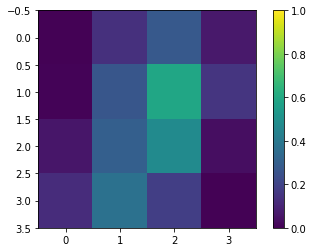

In [5]:
print(train_data[0][1])
plt.imshow(train_data[0][0][0].numpy(), vmin=0, vmax=1); plt.colorbar()

In [6]:
# From TFQ.
def remove_contradicting(dataset):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x, y in dataset:
        mapping[tuple(x.flatten().numpy())].add(int(y))
    
    new_x = []
    new_y = []
    for x, y in dataset:
        labels = mapping[tuple(x.flatten().numpy())]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(list(labels)[0])
        else:
            # Throw out images that match more than one label.
            pass
    
    num_3 = sum(1 for value in mapping.values() if 3 in value or 1 in value)
    num_6 = sum(1 for value in mapping.values() if 6 in value or -1 in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(dataset))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    #return new_x, new_y

In [9]:
remove_contradicting(train_data)
len(train_data)

Number of unique images: 12049
Number of 3s:  6131
Number of 6s:  5918
Number of contradictory images:  0

Initial number of examples:  12049
Remaining non-contradictory examples:  12049


12049

In [10]:
THRESHOLD = 0.2
train_data_bin = torch.utils.data.TensorDataset(torch.cat([x > THRESHOLD for x, _ in train_data]), torch.tensor([1 if y == 3 else -1 for _, y in train_data]))
test_data_bin = torch.utils.data.TensorDataset(torch.cat([x > THRESHOLD for x, _ in test_data]), torch.tensor([1 if y == 3 else -1 for _, y in test_data]))

In [14]:
remove_contradicting(train_data_bin)
len(train_data_bin)

Number of unique images: 315
Number of 3s:  215
Number of 6s:  154
Number of contradictory images:  54

Initial number of examples:  12049
Remaining non-contradictory examples:  4613


12049

In [15]:
def model_circuit(image, params):
    bits = tuple(image.detach().reshape(-1).numpy().nonzero()[0])
    c = Circuit()
    if bits:
        c.x[bits]
    c.x[16].h[16]
    params = tuple(params.detach().numpy())
    for i in range(16):
        c.rxx(params[i])[16, i]
    for i in range(16):
        c.rzz(params[i + 16])[16, i]
    c.h[16]
    return c

model_readout = Z[16]

In [16]:
# model_circuit(train_data_bin[0][0], torch.ones(32)).run_with_ibmq(returns='draw')

In [17]:
class GeneralFunctionWithForwardDifference(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f, xs, weight):
        def f_each(x, weight):
            return torch.tensor([f(x, weight) for x in xs], dtype=torch.float64)
        ys = f_each(xs, weight)
        ctx.save_for_backward(xs, ys, weight)
        ctx.f = f_each
        return ys
        
    @staticmethod
    def backward(ctx, grad_output):
        xs, ys, weight = ctx.saved_tensors
        dw = 0.001
        diff = []
        weight = weight.detach()
        for i in range(len(weight)):
            weight[i] += dw
            diff.append(torch.sum(grad_output * (ctx.f(xs, weight) - ys)))
            weight[i] -= dw
        diff = torch.tensor(diff) / dw
        #print("grad_output", grad_output, "end")
        #print(diff)
        return None, None, diff

In [18]:
from blueqat.vqe import sparse_expectation

class PQC(torch.nn.Module):
    def __init__(self, model_circuit, n_params, n_qubits, readout_operators, initial_circuit=None):
        super(PQC, self).__init__()
        if initial_circuit is None:
            initial_circuit = Circuit()
        initial_circuit.make_cache()
        self.initial_circuit = initial_circuit
        self.model_circuit = model_circuit
        self.readout_operators = readout_operators
        self.sparses = [op.to_matrix(n_qubits=n_qubits, sparse='csc') for op in readout_operators]
        self.weight = torch.nn.parameter.Parameter(torch.Tensor(n_params))
        torch.nn.init.uniform_(self.weight, 0.0, 2 * np.pi)
        
    def forward(self, x):
        def f(x, weight):
            c = self.initial_circuit.copy()
            c += self.model_circuit(x, self.weight)
            v = c.run()
            return [sparse_expectation(sparse, v) for sparse in self.sparses]
        return GeneralFunctionWithForwardDifference.apply(f, x, self.weight)

In [19]:
class HingeLoss(torch.nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
        self.loss = torch.nn.MarginRankingLoss(margin=1.)

    def forward(self, x, y):
        zeros = torch.zeros_like(x)
        return self.loss(x, zeros, y) # input1, input2, tartget

In [20]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()
        self.loss = torch.nn.BCELoss()

    def forward(self, x, y):
        x = (x + 1.0) / 2.0
        y = (y + 1.0) / 2.0
        return self.loss(x, y)

In [21]:
def accuracy(xs, ys):
    xs = xs.detach()
    xs = xs > 0.
    ys = ys > 0.
    return torch.mean((xs == ys).float())

In [22]:
import bokeh
import bokeh.io
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
try:
    from bokeh.io import gridplot
except ImportError:
    from bokeh.layouts import gridplot

output_notebook()

Loading BokehJS ...

In [23]:
epochs = 3
batch_size = 32
x_range_max = len(train_data_bin) // batch_size + 2

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [24]:
from blueqat import BlueqatGlobalSetting
BlueqatGlobalSetting.set_default_backend('numba')

model = PQC(model_circuit, 32, 17, [model_readout])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = HingeLoss()

train_loader = torch.utils.data.DataLoader(train_data_bin, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_bin)

losshist_train = []; losshist_test = []
i = 0
for epoch in range(epochs):
    model.train()
    losses = []
    for im, label in train_loader: # label: 3 is 1, 6 is -1
        out = model(im)
        out = out.reshape(-1).float()
        loss = criterion(out, label)
        losses.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(out, label)
        update(i, float(torch.mean(loss.detach()).item()), float(acc.item()))
        i += 1
    losshist_train.append(torch.mean(torch.tensor(losses)).item())
    
    model.eval()
    losses = []
    for im, label in test_loader:
        out = model(im)
        out = out.reshape(-1).float()
        loss = criterion(out, label)
        losses.append(loss.detach())
    losshist_test.append(torch.mean(torch.tensor(losses)).item())
    
    update(epoch, losshist_train[-1], losshist_test[-1])

0 1.0132359266281128 0.375
1 1.0281637907028198 0.1875
2 0.9980336427688599 0.5625
3 1.01261305809021 0.40625
4 0.999859094619751 0.5625
5 1.007081389427185 0.375
6 1.003542184829712 0.40625
7 1.000455379486084 0.53125
8 1.0056874752044678 0.40625
9 0.9969677925109863 0.53125
10 0.9974995851516724 0.46875
11 1.0001001358032227 0.4375
12 1.0000580549240112 0.46875
13 1.0028553009033203 0.46875
14 1.0035182237625122 0.4375
15 0.997887909412384 0.59375
16 0.9878233671188354 0.75
17 0.9938411712646484 0.625
18 0.9942618608474731 0.6875
19 0.9932988882064819 0.59375
20 0.9893931746482849 0.65625
21 1.007421851158142 0.40625
22 0.9990012049674988 0.46875
23 0.9969602823257446 0.53125
24 1.0023548603057861 0.46875
25 0.9943318963050842 0.65625
26 1.0001386404037476 0.5
27 0.9916216731071472 0.625
28 0.9992318153381348 0.53125
29 1.0067135095596313 0.4375
30 0.9954574108123779 0.5625
31 0.9976319670677185 0.5
32 1.0011305809020996 0.5625
33 0.9962366819381714 0.53125
34 0.983023464679718 0.812

275 0.44268032908439636 0.78125
276 0.4813532829284668 0.75
277 0.3406112492084503 0.875
278 0.3619425892829895 0.84375
279 0.4496346712112427 0.8125
280 0.24728572368621826 0.90625
281 0.441173791885376 0.8125
282 0.2750810980796814 0.875
283 0.41564229130744934 0.78125
284 0.40604138374328613 0.8125
285 0.3808736801147461 0.84375
286 0.46694034337997437 0.8125
287 0.483035683631897 0.78125
288 0.37861889600753784 0.875
289 0.4497416019439697 0.78125
290 0.3764769732952118 0.84375
291 0.3494316339492798 0.875
292 0.499079167842865 0.78125
293 0.4907575249671936 0.78125
294 0.6146500706672668 0.65625
295 0.3988613784313202 0.875
296 0.42279890179634094 0.8125
297 0.4320105016231537 0.8125
298 0.35263338685035706 0.84375
299 0.386883020401001 0.84375
300 0.2210882157087326 0.9375
301 0.2987397313117981 0.9375
302 0.3189532160758972 0.875
303 0.33170369267463684 0.8125
304 0.23420622944831848 0.90625
305 0.40876251459121704 0.8125
306 0.48278480768203735 0.84375
307 0.36905333399772644 0

RuntimeError: python_error

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losshist_train, label='train')
plt.plot(losshist_test, label='test')
plt.legend()

In [ ]:
torch.save(model.state_dict(), 'mnist.pytorch')

In [25]:
count = 0; tot = 0
for im, label in test_loader:
    model.eval()
    out = model(im)
    if (out.item() > 0.5) == (label.item() > 0.5):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')

Test result: 1576/1968 (80.08130081300813 %)


## Another test

In above test, results such that {out=0.2, label=-1} is judged as validly predicted.  
However it should be judged as incorrect, so I made another test function.

In [26]:
count = 0; tot = 0
THRESHOLD = 0.
for im, label in test_loader:
    model.eval()
    out = model(im)
    if (out.item() > THRESHOLD) and (label.item() > THRESHOLD):
        count += 1
    elif (out.item() < -1.0 * THRESHOLD) and (label.item() < -1.0 * THRESHOLD):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')

Test result: 1697/1968 (86.22967479674797 %)


## Classical NN

In [ ]:
relu = torch.nn.functional.relu
tanh = torch.nn.functional.tanh
class ClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(16, 8)
        self.fc2 = torch.nn.Linear(8, 4)
        self.fc3 = torch.nn.Linear(4, 1)
    def forward(self, x):
        x = x.reshape(-1, 16)
        x = relu(self.fc1(x.float()))
        x = relu(self.fc2(x))
        x = tanh(self.fc3(x))
        return x

In [ ]:
epochs = 3
c_batch_size = 32
x_range_max = epochs + 1

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [ ]:
relu = torch.nn.functional.relu
tanh = torch.nn.functional.tanh
class TinyClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(16, 2)
        self.fc2 = torch.nn.Linear(2, 1)
    def forward(self, x):
        x = x.reshape(-1, 16)
        x = relu(self.fc1(x.float()))
        x = tanh(self.fc2(x.float()))
        return x

In [ ]:
tiny_model = TinyClassicalModel()
sum(p.numel() for p in tiny_model.parameters())

In [ ]:
epochs = 3
c_batch_size = 32
x_range_max = epochs + 1

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [ ]:
optimizer = torch.optim.Adam(tiny_model.parameters(), lr=0.02)
criterion = HingeLoss()

train_loader = torch.utils.data.DataLoader(train_data_bin, batch_size=c_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_bin)

losshist_train = []; losshist_test = []
i = 0
for epoch in range(epochs):
    tiny_model.train()
    losses = []; acces = []
    for im, label in train_loader:
        out = tiny_model(im)
        #print(out)
        loss = criterion(out.reshape(-1), label)
        losses.append(float(loss.detach()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(out.reshape(-1), label)
        acces.append(float(acc))
        i += 1
    update(epoch, float(torch.mean(torch.tensor(losses))),\
           float(torch.mean(torch.tensor(acces))))
    losshist_train.append(torch.mean(torch.tensor(losses)).item())
    
    tiny_model.eval()
    losses = []
    for im, label in test_loader:
        out = tiny_model(im)
        loss = criterion(out.reshape(-1), label)
        losses.append(loss.detach())
    losshist_test.append(torch.mean(torch.tensor(losses)).item())

In [ ]:
count = 0; tot = 0
for im, label in test_loader:
    tiny_model.eval()
    out = tiny_model(im)
    if (out.item() > 0.5) == (label.item() > 0.5):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')